In [1]:
!pip install beautifulsoup4 requests

In [1]:
import concurrent.futures
import requests
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import re
import csv
import time
import pandas as pd
import numpy as np
import nltk
import collections
from nltk.tokenize import word_tokenize
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import cv2
import urllib

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DoctorWho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DoctorWho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DoctorWho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DoctorWho\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [53]:
class webCrawler:
    def __init__(self, theUrl:str):
        article = requests.get(theUrl)
        self.soup = bs(article.content, "html.parser")
        self.url = theUrl
        self.subArticles = self.get_articles()
        self.allInfo = self.get_All_Info()
        
        
        
    def get_articles(self) -> list: 
        articles = []
        theSoup = self.soup
        buttons = theSoup.find_all('a', {'class': re.compile(r'.*paginator__button.*')})
        buttonsList = [int(b.text) for b in buttons]
        buttonsList.sort(reverse=True)
        threads = min(20, buttonsList[0])
        newUrl = re.search('https?://[a-zA-Z.]*', self.url)
        pagePart = buttons[0].get("href")
        newUrls = [ (newUrl.group(0) + re.sub("p=\d+", "p="+ str(i), pagePart)) for i in range(1, buttonsList[0] + 1)]
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
            for result in executor.map(self.findArticlesInPage, newUrls):
                articles.extend(result)
                
        return articles
    
    
    
    def findArticlesInPage(self, newUrl) -> list:
        articles = []
        nextPage = requests.get(newUrl)
        theSoup = bs(nextPage.content, "html.parser")
        divs1 = theSoup.find_all('div', {'class': re.compile(r'.*topstories-news.*')})
        divs2 = theSoup.find_all('div', {'class': re.compile(r'.*listing__articles.*')})
        for a in divs1: 
            b = a.findChildren("article")
            for art in b: 
                articles.append(art)  
        for a in divs2: 
            b = a.findChildren("article")
            for art in b: 
                articles.append(art)
        time.sleep(0.25)
        return articles
    
    
    
    def get_All_Info(self) -> list:
        infoPerArticle = []
        threads = min(30, len(self.subArticles))
        with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
            for result in executor.map(self.get_All_Info_Helper, self.subArticles):
                infoPerArticle.append(result)
        return infoPerArticle
    
    def get_All_Info_Helper(self, a) -> dict:
        images = []
        im = a.findChildren("img")[0]
        temp = self.extract_img_info(im)
        images.append(temp)
        time.sleep(0.25)
        newUrl = re.search('https?://[a-zA-Z.]*', self.url)
        newUrl = newUrl.group(0) + a.findChildren("a")[0].get("href")
        theArticle = requests.get(newUrl)
        theSoup = bs(theArticle.content, "html.parser")
        title = theSoup.find_all("h1")
        title = title[0].text if title else theSoup.find("h2").text
        theBod = theSoup.find_all('div', {'class': re.compile(r'.*article-content.*')})
        if theBod == None:
            theBod = theSoup.find_all('section', {'class': re.compile(r'.*article__container.*')})
            if theBod == None: 
                theBod = theSoup.find_all("main")
                print(title, newUrl)
        theBod = theBod[0]
        allImgs = theBod.findChildren("img")
        for i in allImgs:
            temp = self.extract_img_info(i)
            images.append(temp)
        temp = {}
        temp["Title"] = re.sub(" *\n *", "", title)
        temp["Images"] = images
        temp["URL"] = newUrl
        temp["Text"] = [t.text for t in theBod.findChildren("p")]
        return temp
        
        
    
    def extract_img_info(self, im) -> dict:
        text = im.get("alt")
        link = im.get("src")
        if not str(link).startswith("http"):
            link = im.get("data-src")
        temp = {}
        temp["Image_Description"] = text
        temp["Link"] = link
        return temp

In [59]:
c = webCrawler("https://www.euronews.com/tag/cyber-attacks")

In [60]:
info = c.allInfo

In [61]:
for i in info: 
    d = i["Images"]
    t = i["Title"]
    l = i["URL"]
    for im in d: 
        im["Article_Title"] = t
        im["Article_URL"] = l

In [62]:
fn = 'CyberCrimeArticles-new.csv'
with open(fn, 'w', newline='') as f:
    w = csv.DictWriter(f, ['Image_Description', 'Link', 'Article_Title', 'Article_URL'])
    w.writeheader()
    for i in info:
        for im in i["Images"]:
            w.writerow(im)

In [2]:
# Initializing the dataset by reading the data from the CSV file 
dataset = pd.read_csv('CyberCrimeArticles-new.csv', encoding='latin-1')
dataset.head()

,Image_Description,Link,Article_Title,Article_URL
0,Anonymous has claimed cyber attacks on Russian...,https://static.euronews.com/articles/stories/0...,Ukraine war: What part is hackers collective ...,https://www.euronews.com/next/2022/02/28/ukrai...
1,Euronews,https://static.euronews.com/articles/stories/0...,Ukraine war: What part is hackers collective ...,https://www.euronews.com/next/2022/02/28/ukrai...
2,"As well as protecting against cyberattacks, Uk...",https://static.euronews.com/articles/stories/0...,Ukraine war: Ukrainians announce the launch of...,https://www.euronews.com/next/2022/02/26/ukrai...
3,Cyber attacks can disrupt essential services a...,https://static.euronews.com/articles/stories/0...,Is Russia using cyberattacks in the war with U...,https://www.euronews.com/next/2022/02/24/russi...
4,The cyberattack affected state-owned banks and...,https://static.euronews.com/articles/stories/0...,Ukraine's defence ministry and two banks targe...,https://www.euronews.com/my-europe/2022/02/15/...


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Image_Description  74 non-null     object
 1   Link               93 non-null     object
 2   Article_Title      93 non-null     object
 3   Article_URL        93 non-null     object
dtypes: object(4)
memory usage: 3.0+ KB


In [4]:
def stats(im):
    temp = [im.min(), im.max(), im.mean(), im.std()]
    return temp

In [45]:
def cluster(paths):
    # Variables
    number_clusters = 2

    featurelist = []
    theImages = [] 
    threads = min(30, len(paths))
    with concurrent.futures.ThreadPoolExecutor(max_workers=threads) as executor:
        for result in executor.map(clusterHelper, paths):
            if result is None:
                continue
            featurelist.append(stats(result))
            theImages.append(result)
            
    # Clustering
    kmeans = KMeans(n_clusters=number_clusters, random_state=0).fit(np.array(featurelist))
    return (theImages, featurelist, kmeans)

    

def clusterHelper(imagepath):
    #print("Image: ", imagepath)
    if imagepath != imagepath:
        return None
    try:
        req = urllib.request.urlopen(imagepath)
    except:
        return None
    arr = np.asarray(bytearray(req.read()), dtype=np.uint8)
    im = cv2.imdecode(arr, -1)
    #b, g, r = cv2.split(im)
    #bh, t = np.histogram(b, bins=256)
    #gh, t = np.histogram(g, bins=256)
    #rh, t = np.histogram(r, bins=256)
    #hist = np.hstack((bh,gh,rh)).ravel()

    featurelist.append(stats(im))
    time.sleep(0.3)
    return im
    

In [38]:
theImages, featurelist, kmeans = cluster(dataset["Link"])

In [8]:
# Copy with cluster name
for i, l in zip(theImages, kmeans.labels_):
    cv2.putText(i,str(l), (101,101), cv2.FONT_HERSHEY_SIMPLEX, 2, 255)
    cv2.imshow ("out.png", i)
    cv2.waitKey(0)
cv2.destroyAllWindows()

In [39]:
kmeans.labels_

array([0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1])

In [17]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
print(order_centroids)

[[1 2 3 0]
 [1 2 3 0]]


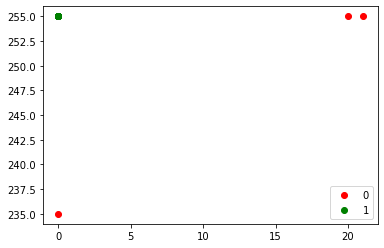

In [30]:
u_labels = np.unique(kmeans.labels_)
zeros, ones = {"Min": [], "Max":[], "Mean":[], "Std":[]},  {"Min": [], "Max":[], "Mean":[], "Std":[]}
for f, l in zip(featurelist, kmeans.labels_):
    if(l == 0):
        zeros["Min"].append(f[0])
        zeros["Max"].append(f[1])
        zeros["Mean"].append(f[2])
        zeros["Std"].append(f[3])
    else: 
        ones["Min"].append(f[0])
        ones["Max"].append(f[1])
        ones["Mean"].append(f[2])
        ones["Std"].append(f[3])
        
    
#plotting the results:
plt.scatter(zeros["Min"] , zeros["Max"] , label = 0, color='red')
plt.scatter(ones["Min"] , ones["Max"] , label = 1, color='green')
plt.legend()
plt.show()

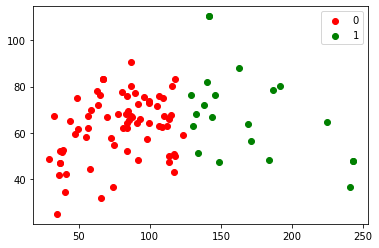

In [31]:
#plotting the results:
plt.scatter(zeros["Mean"] , zeros["Std"] , label = 0, color='red')
plt.scatter(ones["Mean"] , ones["Std"] , label = 1, color='green')
plt.legend()
plt.show()

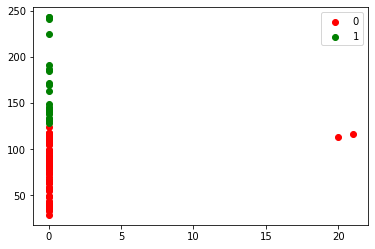

In [32]:
plt.scatter(zeros["Min"] , zeros["Mean"] , label = 0, color='red')
plt.scatter(ones["Min"] , ones["Mean"] , label = 1, color='green')
plt.legend()
plt.show()

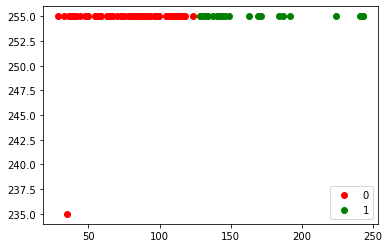

In [33]:
plt.scatter(zeros["Mean"] , zeros["Max"] , label = 0, color='red')
plt.scatter(ones["Mean"] , ones["Max"] , label = 1, color='green')
plt.legend()
plt.show()

In [6]:
def lemmatizeList( li ):
    lemmatizer = WordNetLemmatizer()
    res = []
    for theWord, theTag in nltk.pos_tag(li):
        if theTag.startswith("VB"):
            res.append( lemmatizer.lemmatize(theWord, pos = 'v') )
        elif theTag.startswith("NN"):
            res.append( lemmatizer.lemmatize(theWord, pos = 'n') )
        elif theTag.startswith("RB"):
            res.append( lemmatizer.lemmatize(theWord, pos = 'r') )
        elif theTag.startswith("JJ"):
            res.append( lemmatizer.lemmatize(theWord, pos = 'a') )
    return res


In [13]:
stop_words = set(stopwords.words('english'))
allwords = []

for i in range(0, len(dataset['Image_Description'])):
    sent = dataset.loc[i,'Image_Description']
    if sent != sent:
        continue
        
    # Use a regex to catch all single letter words, html tags or other non-alphanumeric characters then substitute them with a space
    cleaned = re.sub(r"(?:(?:^|\s+)[a-zA-Z]\s+)|<.*?>|\W", ' ', sent)
    
    # Tokenize the sentence using word_tokenize method
    tokenized_sent = [word for word in word_tokenize(cleaned.lower())]

    # remove stopwords
    noStop = [word for word in tokenized_sent if word not in stop_words]
    
    # lemmatize sentence 
    lemmatized_words = lemmatizeList( noStop )
    
    allwords.append( " ".join(lemmatized_words) )

In [14]:
tfidf_vectorizer = TfidfVectorizer(min_df = 2, max_df = 0.6, ngram_range=(1,3))
vect = tfidf_vectorizer.fit_transform(allwords)

In [15]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(vect)

KMeans(max_iter=100, n_clusters=2, n_init=1)

In [16]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
print(order_centroids)
terms = tfidf_vectorizer.get_feature_names()
print(terms)

[[ 52   3  40  63  39  71  54  86  55  44  41  67 119  49  94  70  85  16
   17  72  18  23  58  81 101  47  77 134 133 128  73  83  74  64  56 118
  141 103  62  42  43  45  78  97  46  79 111  88 109 108  87  53  12 110
   61  95  96 131  82 132   5 137 112 116   4 138 113  27  66  80 139  36
    2  29  37   1  35  34  33  32  31   7   8  30   6  25  28  20  11  14
   15  38 136  19  21  26  22 135  10   9  24  13 104 125 130  91 114  75
   76  84 107  89  90  92 129  93 106  98  99 100 105 102 115 140  69  68
  127  48 126  50  51 124 123 122  57 121  59  60 120 117  65   0]
 [ 30   5  31 102 104  34 103  27 111  19 105 127 117  36  49 135  37 116
   22  57  38 136 121  24  89  90  48  84 124 126 125  60  32  65  59   6
   71  58  12  29 122 130  28 129 123  35 120 112  53 110 137  83   4  23
   15  14  91  92  93  13  50  10   9  51  11  40  16  44  66  77 114 100
  106 107   8   7  75  98  33   2   1 139 115  99   0  69  76  26  25  20
   21 140  68  62  80 138  74 113 128   3  17

In [17]:
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Cluster 0:
 euronews
 ap
 cybersecurity
 hacker
 cyberattack
 know
 european
 president
 europol
 digital
Cluster 1:
 cyber
 attack
 cyber attack
 russia
 russian cyber
 cyber crime
 russian
 crime
 security
 claim


In [54]:
c2 = webCrawler("https://www.euronews.com/tag/business")

In [55]:
info2 = c2.allInfo

In [56]:
for i in info2: 
    d = i["Images"]
    t = i["Title"]
    l = i["URL"]
    p = i["Text"]
    for im in d: 
        im["Article_Title"] = t
        im["Article_URL"] = l
        im["Article_Text"] = p

In [58]:
fn = 'CyberCrimeArticles-3.csv'
with open(fn, 'w', newline='', encoding='utf-8') as f:
    w = csv.DictWriter(f, ['Image_Description', 'Link', 'Article_Title', 'Article_URL', 'Article_Text'])
    w.writeheader()
    for i in info2:
        for im in i["Images"]:
            w.writerow(im)

In [18]:
# Initializing the dataset by reading the data from the CSV file 
dataset2 = pd.read_csv('CyberCrimeArticles-3.csv', encoding='latin-1')
dataset2.head()

,Image_Description,Link,Article_Title,Article_URL,Article_Text
0,Rapid delivery's rapid rise has led to tension...,https://static.euronews.com/articles/stories/0...,Dutch cities temporarily banned 10-minute deli...,https://www.euronews.com/next/2022/02/24/dutch...,"['Noise, reckless cycling and blacked-out wind..."
1,Start-up conference Step in Dubai Internet City.,https://static.euronews.com/articles/stories/0...,How Dubai Internet City is becoming a hub for ...,https://www.euronews.com/next/2022/02/23/how-d...,"['Khazna, one of the largest data centre infra..."
2,Meta CEO Mark Zuckerberg said the company's co...,https://static.euronews.com/articles/stories/0...,"Ahoy, Metamates! Meta continues rebranding eff...",https://www.euronews.com/next/2022/02/16/ahoy-...,"[""Employees at Facebook's parent company Meta ..."
3,Carolyn Kaster/AP Photo,https://static.euronews.com/articles/stories/0...,"Ahoy, Metamates! Meta continues rebranding eff...",https://www.euronews.com/next/2022/02/16/ahoy-...,"[""Employees at Facebook's parent company Meta ..."
4,Choosing a green pension could be better for t...,https://static.euronews.com/articles/stories/0...,Green pensions could be the âmost powerful w...,https://www.euronews.com/green/2022/02/15/gree...,['Switching to a sustainable pension could be ...


In [19]:
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1874 entries, 0 to 1873
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Image_Description  1588 non-null   object
 1   Link               1863 non-null   object
 2   Article_Title      1874 non-null   object
 3   Article_URL        1874 non-null   object
 4   Article_Text       1874 non-null   object
dtypes: object(5)
memory usage: 73.3+ KB


In [46]:
theImages2, featurelist2, kmeans2 = cluster(dataset2["Link"])

In [47]:
kmeans2.labels_

array([1, 0, 1, ..., 1, 0, 0])

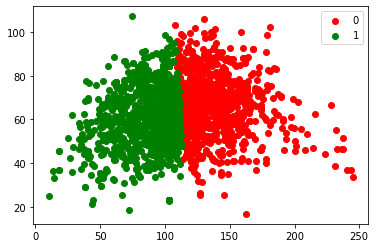

In [48]:
u_labels = np.unique(kmeans2.labels_)
zeros, ones = {"Min": [], "Max":[], "Mean":[], "Std":[]},  {"Min": [], "Max":[], "Mean":[], "Std":[]}
for f, l in zip(featurelist2, kmeans2.labels_):
    if(l == 0):
        zeros["Min"].append(f[0])
        zeros["Max"].append(f[1])
        zeros["Mean"].append(f[2])
        zeros["Std"].append(f[3])
    else: 
        ones["Min"].append(f[0])
        ones["Max"].append(f[1])
        ones["Mean"].append(f[2])
        ones["Std"].append(f[3])
        
    
#plotting the results:
plt.scatter(zeros["Mean"] , zeros["Std"] , label = 0, color='red')
plt.scatter(ones["Mean"] , ones["Std"] , label = 1, color='green')
plt.legend()
plt.show()

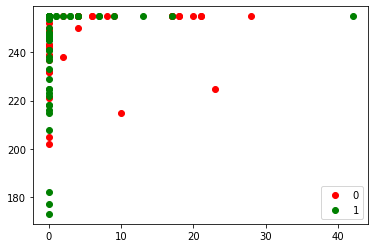

In [49]:
plt.scatter(zeros["Min"] , zeros["Max"] , label = 0, color='red')
plt.scatter(ones["Min"] , ones["Max"] , label = 1, color='green')
plt.legend()
plt.show()

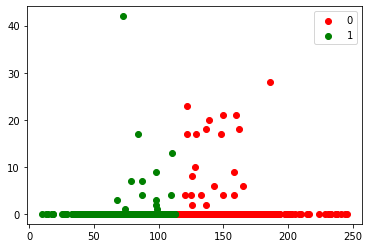

In [50]:
plt.scatter(zeros["Mean"] , zeros["Min"] , label = 0, color='red')
plt.scatter(ones["Mean"] , ones["Min"] , label = 1, color='green')
plt.legend()
plt.show()